# Initialize

In [13]:
#@title Import {display-mode: "form"}
import math
import torch
from torch import nn

# Model

In [14]:
#@title Swish {display-mode: "form"}
class Swish(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [15]:
#@title FeatureEx1d {display-mode: "form"}
class FeatureEx1d(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
        nn.linear(input_size, 256),
        nn.functional.relu(),
        nn.linear(256, 128),
        nn.functional.relu(),
        nn.linear(128, 64),
        nn.functional.relu()
    )

  def forward(self, x):
    return self.layers(x)

In [16]:
#@title SEblock {display-mode: "form"}
class SEblock(nn.Module):
  def __init__(self, ch_in, ch_sq):
    super().__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(ch_in, ch_sq, 1),
        Swish(),
        nn.Conv2d(ch_sq, ch_in, 1),
    )
    self.se.apply(weight_init)

  def forward(self, x):
    return x * torch.sigmoid(self.se(x))

def weight_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight)

  if isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight)
    nn.init.zeros_(m.bias)

In [17]:
#@title ConvBNFirst {display-mode: "form"}
class ConvBNFirst(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size=(3, 257), stride=(1, 257), padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [18]:
#@title ConvBN {display-mode: "form"}
class ConvBN(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size, stride=1, padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [19]:
#@title DropConnect {display-mode: "form"}
class DropConnect(nn.Module):
  def __init__(self, drop_rate):
    super().__init__()
    self.drop_rate=drop_rate

  def forward(self, x):
    if self.training:
      keep_rate=1.0-self.drop_rate
      r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
      r+=keep_rate
      mask=r.floor()
      return x.div(keep_rate)*mask
    else:
      return x

In [20]:
#@title BMConvBlock {display-mode: "form"}
class BMConvBlock(nn.Module):
  def __init__(self,ch_in,ch_out,expand_ratio,stride,kernel_size,reduction_ratio=4,drop_connect_rate=0.2):
    super().__init__()
    self.use_residual = (ch_in==ch_out) & (stride==1)
    ch_med = int(ch_in*expand_ratio)
    ch_sq  = max(1, ch_in//reduction_ratio)

    if expand_ratio != 1.0:
      layers = [ConvBN(ch_in, ch_med, 1), Swish()]
    else:
      layers = []
    
    layers.extend([ConvBN(ch_med, ch_med, kernel_size, stride=stride, padding=0, groups=ch_med),
                  Swish(),
                  SEblock(ch_med, ch_sq),
                  ConvBN(ch_med, ch_out, 1),
                  ])
    
    if self.use_residual:
      self.drop_connect = DropConnect(drop_connect_rate)

    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    if self.use_residual:
      return x + self.drop_connect(self.layers(x))
    else:
      return self.layers(x)

In [21]:
#@title Flatten {display-mode: "form"}
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [22]:
#@title MultiModalNet {display-mode: "form"}
class MultiModalNet(nn.Module):
  def __init__(self,
               width_mult=2.0,
               depth_mult=1.0,
               resolution=None,
               dropout_rate=0.2,
               num_1d_features=10,
               num_classes=4,
               input_ch=3):
    super().__init__()
    '''
    # expand_ratio, channel, repeats, stride, kernel_size                   
    settings = [
        [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112                   
        [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56                   
        [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28                   
        [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14                   
        [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14                   
        [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7                   
        [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7]                  
    ]
    ch_out = int(math.ceil(32*width_mult))
    features = [nn.AdaptiveAvgPool2d(resolution)] if resolution else []
    features.extend([ConvBNFirst(input_ch, ch_out), Swish()])     # -> [32, 3, 3, 3]

    ch_in = ch_out
    for t, c, n, s, k in settings:
      ch_out = int(math.ceil(c*width_mult))
      repeats = int(math.ceil(n*depth_mult))
      for i in range(repeats):
        stride = s if i==0 else 1
        features.extend([BMConvBlock(ch_in, ch_out, t, stride, k)])
        ch_in = ch_out

    '''
    features = [BMConvBlock(input_ch, 32, expand_ratio=6, stride=(1,257), kernel_size=(3, 257))]
    features.extend([BMConvBlock(32, 32, expand_ratio=6, stride=(2,1), kernel_size=(5,1))])
    features.extend([BMConvBlock(32, 32, expand_ratio=6, stride=(2,1), kernel_size=(5,1))])
    features.extend([BMConvBlock(32, 32, expand_ratio=6, stride=(2,1), kernel_size=(5,1))])

    ch_last = int(math.ceil(1280*width_mult))
    features.extend([ConvBN(32, ch_last, 1), Swish()])

    self.features2d = nn.Sequential(*features)
    self.reshape = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Dropout(dropout_rate),
        nn.Linear(ch_last, 128)
    )
    self.classifier = nn.Sequential(
        nn.Linear(128*2, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
    )

    self.features1d = nn.Sequential(
        nn.Linear(num_1d_features, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
    )

  def forward(self, x):
    x1=self.features2d(x[1])
    x1=self.reshape(x1)
    x0=self.features1d(x[0])
    x = torch.cat((x0,x1), dim=1)
    x=self.classifier(x)

    return x

# Dataset

In [23]:
RESEARCH_WORK_PATH = "/content/drive/MyDrive/Colab Notebooks/BachelorResearch/"

In [24]:
import shutil
import os


data_dir = "/content/datas/"
if os.path.exists(data_dir):
  shutil.rmtree(data_dir)
for dirs in os.listdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/"):
  if "Q" in dirs:
    shutil.copytree(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/" + dirs, data_dir + dirs)

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/"  + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = data_dir + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

Q1 9200
Q2 9200
Q3 9200
Q4 9200
Q1 9200
Q2 9200
Q3 9200
Q4 9200


In [25]:
import os
def make_filepath_list(root, train_rate=0.8):
  train_file_list = []
  valid_file_list = []

  for dirs in os.listdir(root):
    if "Q" in dirs:
      file_dir = os.path.join(root, dirs)
      file_list = os.listdir(file_dir)


      for f in file_list:
        split_num = int(f.split(".")[1].split("_")[-1])
        if split_num % 5 == 4:
          valid_file_list.append(os.path.join(root, dirs, f).replace('\\', '/'))
        else:
          train_file_list.append(os.path.join(root, dirs, f).replace('\\', '/'))

  
  return train_file_list, valid_file_list


In [26]:
from torch.utils import data
import numpy as np
import librosa
import pickle
import torch
import cv2

class musicDataset(data.Dataset):

  def __init__(self, file_list, classes, phase='train'):
    self.file_list = file_list
    self.classes = classes
    self.phase = phase

  def __len__(self):
    return len(self.file_list)


  def __getitem__(self, index):
    pickle_path = self.file_list[index]
    x,y = pickle.load(open(pickle_path, mode="rb"))
    return x, y


train_file_list, valid_file_list = make_filepath_list(data_dir)

print('学習データ数 : ', len(train_file_list))
print(train_file_list[0])

print('検証データ数 : ', len(valid_file_list))
print(valid_file_list[0])

q_classes = "Q1 Q2 Q3 Q4".split(" ")

train_dataset = musicDataset(
    file_list=train_file_list, classes=q_classes, phase='train'
)

valid_dataset = musicDataset(
    file_list=valid_file_list, classes=q_classes, phase='valid'
)


index = 0
print("Dataset1 shape:", train_dataset.__getitem__(index)[0][0].size())
print("Dataset2 shape:", train_dataset.__getitem__(index)[0][1].size())
print("Dataset label:", train_dataset.__getitem__(index)[1])

学習データ数 :  29600
/content/datas/Q2/Q2.MT0014878397_0.wav.pickle
検証データ数 :  7200
/content/datas/Q2/Q2.MT0008455201_9.wav.pickle
Dataset1 shape: torch.Size([26])
Dataset2 shape: torch.Size([1, 431, 257])
Dataset label: 1


# DataLoader

In [27]:
# バッチサイズの指定
batch_size = 64

# DataLoaderを作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# pin_mem and num_workers are acceleration technique -> https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587#11-num_workers

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 動作確認
# イテレータに変換
batch_iterator = iter(dataloaders_dict['train'])

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)

print(inputs[0].size())
print(inputs[1].size())
print(labels)


torch.Size([64, 26])
torch.Size([64, 1, 431, 257])
tensor([1, 0, 1, 1, 2, 2, 2, 2, 0, 1, 1, 3, 3, 3, 1, 1, 3, 1, 0, 3, 3, 0, 3, 3,
        3, 2, 3, 2, 0, 0, 1, 2, 3, 0, 2, 3, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 2, 3, 2, 0, 0, 1, 1, 0, 3, 3, 0, 0, 3, 0, 1])


# Optimizer, Criterion

In [28]:
torch_clearlizer = False #@param {type: "boolean"}

if torch_clearlizer:
  del train_dataset
  del valid_dataset
  del train_dataloader
  del valid_dataloader
  del labels
  del loss_hist
  del acc_hist
  del optimizer
  del criterion
  torch.cuda.empty_cache()

In [29]:
from torch import optim

model     = MultiModalNet(input_ch=1, num_classes=4, num_1d_features=train_dataset.__getitem__(index)[0][0].size(0)).to('cuda')
optimizer = optim.SGD(model.parameters(),lr=0.1) 
criterion = nn.CrossEntropyLoss()

SGD -> じわっとloss減ってく


# Training

In [30]:
from tqdm import tqdm
# エポック数
num_epochs = 200


loss_hist = [[],[]]
acc_hist = [[],[]]

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-------------')
  
  for phase in ['train', 'valid']:
      
    if phase == 'train':
      # モデルを訓練モードに設定
      model.train()
    else:
      # モデルを推論モードに設定
      model.eval()
    
    # 損失和
    epoch_loss = 0.0
    # 正解数
    epoch_corrects = 0
    
    # DataLoaderからデータをバッチごとに取り出す
    with tqdm(dataloaders_dict[phase],unit='batch',colour='green' if phase == 'train' else 'red') as pbar:
      pbar.set_description('['+phase+'] Epoch %d'% (epoch+1))
      for inputs, labels in pbar:
        inputs = [inputs[0].to('cuda') , inputs[1].to('cuda')]
        labels = labels.to('cuda')
        # optimizerの初期化
        optimizer.zero_grad()
        
        # 学習時のみ勾配を計算させる設定にする
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          
          # 損失を計算
          loss = criterion(outputs, labels)
          
          # ラベルを予測
          _, preds = torch.max(outputs, 1)
          
          # 訓練時はバックプロパゲーション
          if phase == 'train':
            # 逆伝搬の計算
            loss.backward()
            # パラメータの更新
            optimizer.step()
          
          # イテレーション結果の計算
          # lossの合計を更新
          # PyTorchの仕様上各バッチ内での平均のlossが計算される。
          # データ数を掛けることで平均から合計に変換をしている。
          # 損失和は「全データの損失/データ数」で計算されるため、
          # 平均のままだと損失和を求めることができないため。
          l = loss.item()
          epoch_loss += l * inputs[0].size(0)
          pbar.set_postfix(dict(loss=l))

          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

    # epochごとのlossと正解率を表示
    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
    epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
    loss_hist[0].append(epoch_loss) if phase == 'train' else loss_hist[1].append(epoch_loss)
    acc_hist[0].append(epoch_acc)      if phase == 'train' else acc_hist[1].append(epoch_acc)

    print('[{}] Epoch {} Result: Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch+1, epoch_loss, epoch_acc))

Epoch 1/200
-------------


[train] Epoch 1: 100%|██████████| 463/463 [03:48<00:00,  2.02batch/s, loss=1.15]


[train] Epoch 1 Result: Loss: 1.2538 Acc: 0.4360



[valid] Epoch 1: 100%|██████████| 113/113 [00:30<00:00,  3.72batch/s, loss=1.04]


[valid] Epoch 1 Result: Loss: 1.1965 Acc: 0.5124

Epoch 2/200
-------------


[train] Epoch 2: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=1.11]


[train] Epoch 2 Result: Loss: 1.1244 Acc: 0.6000



[valid] Epoch 2: 100%|██████████| 113/113 [00:29<00:00,  3.77batch/s, loss=1.15]


[valid] Epoch 2 Result: Loss: 1.0835 Acc: 0.6514

Epoch 3/200
-------------


[train] Epoch 3: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=1.1]


[train] Epoch 3 Result: Loss: 1.0740 Acc: 0.6611



[valid] Epoch 3: 100%|██████████| 113/113 [00:30<00:00,  3.66batch/s, loss=0.941]


[valid] Epoch 3 Result: Loss: 1.1804 Acc: 0.5479

Epoch 4/200
-------------


[train] Epoch 4: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=1.02]


[train] Epoch 4 Result: Loss: 1.0387 Acc: 0.6998



[valid] Epoch 4: 100%|██████████| 113/113 [00:30<00:00,  3.68batch/s, loss=0.911]


[valid] Epoch 4 Result: Loss: 1.0071 Acc: 0.7371

Epoch 5/200
-------------


[train] Epoch 5: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.958]


[train] Epoch 5 Result: Loss: 1.0117 Acc: 0.7273



[valid] Epoch 5: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.939]


[valid] Epoch 5 Result: Loss: 0.9924 Acc: 0.7500

Epoch 6/200
-------------


[train] Epoch 6: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.979]


[train] Epoch 6 Result: Loss: 0.9857 Acc: 0.7568



[valid] Epoch 6: 100%|██████████| 113/113 [00:30<00:00,  3.65batch/s, loss=0.972]


[valid] Epoch 6 Result: Loss: 1.0064 Acc: 0.7315

Epoch 7/200
-------------


[train] Epoch 7: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.945]


[train] Epoch 7 Result: Loss: 0.9680 Acc: 0.7724



[valid] Epoch 7: 100%|██████████| 113/113 [00:31<00:00,  3.63batch/s, loss=0.908]


[valid] Epoch 7 Result: Loss: 0.9495 Acc: 0.7924

Epoch 8/200
-------------


[train] Epoch 8: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.916]


[train] Epoch 8 Result: Loss: 0.9429 Acc: 0.7992



[valid] Epoch 8: 100%|██████████| 113/113 [00:30<00:00,  3.70batch/s, loss=0.902]


[valid] Epoch 8 Result: Loss: 0.9807 Acc: 0.7574

Epoch 9/200
-------------


[train] Epoch 9: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.926]


[train] Epoch 9 Result: Loss: 0.9230 Acc: 0.8201



[valid] Epoch 9: 100%|██████████| 113/113 [00:30<00:00,  3.71batch/s, loss=0.916]


[valid] Epoch 9 Result: Loss: 0.9459 Acc: 0.7951

Epoch 10/200
-------------


[train] Epoch 10: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.9]


[train] Epoch 10 Result: Loss: 0.9095 Acc: 0.8333



[valid] Epoch 10: 100%|██████████| 113/113 [00:31<00:00,  3.61batch/s, loss=0.977]


[valid] Epoch 10 Result: Loss: 0.9877 Acc: 0.7546

Epoch 11/200
-------------


[train] Epoch 11: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.893]


[train] Epoch 11 Result: Loss: 0.8987 Acc: 0.8442



[valid] Epoch 11: 100%|██████████| 113/113 [00:29<00:00,  3.77batch/s, loss=1.21]


[valid] Epoch 11 Result: Loss: 0.9695 Acc: 0.7692

Epoch 12/200
-------------


[train] Epoch 12: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.84]


[train] Epoch 12 Result: Loss: 0.8840 Acc: 0.8593



[valid] Epoch 12: 100%|██████████| 113/113 [00:30<00:00,  3.73batch/s, loss=0.875]


[valid] Epoch 12 Result: Loss: 0.8836 Acc: 0.8597

Epoch 13/200
-------------


[train] Epoch 13: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.804]


[train] Epoch 13 Result: Loss: 0.8708 Acc: 0.8726



[valid] Epoch 13: 100%|██████████| 113/113 [00:30<00:00,  3.67batch/s, loss=0.893]


[valid] Epoch 13 Result: Loss: 0.8610 Acc: 0.8824

Epoch 14/200
-------------


[train] Epoch 14: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.88]


[train] Epoch 14 Result: Loss: 0.8631 Acc: 0.8805



[valid] Epoch 14: 100%|██████████| 113/113 [00:31<00:00,  3.54batch/s, loss=0.851]


[valid] Epoch 14 Result: Loss: 0.8532 Acc: 0.8911

Epoch 15/200
-------------


[train] Epoch 15: 100%|██████████| 463/463 [03:39<00:00,  2.10batch/s, loss=0.979]


[train] Epoch 15 Result: Loss: 0.8550 Acc: 0.8879



[valid] Epoch 15: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.901]


[valid] Epoch 15 Result: Loss: 0.8457 Acc: 0.8988

Epoch 16/200
-------------


[train] Epoch 16: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.783]


[train] Epoch 16 Result: Loss: 0.8486 Acc: 0.8944



[valid] Epoch 16: 100%|██████████| 113/113 [00:30<00:00,  3.71batch/s, loss=0.846]


[valid] Epoch 16 Result: Loss: 0.8654 Acc: 0.8764

Epoch 17/200
-------------


[train] Epoch 17: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.883]


[train] Epoch 17 Result: Loss: 0.8396 Acc: 0.9040



[valid] Epoch 17: 100%|██████████| 113/113 [00:31<00:00,  3.54batch/s, loss=0.87]


[valid] Epoch 17 Result: Loss: 0.8527 Acc: 0.8894

Epoch 18/200
-------------


[train] Epoch 18: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.755]


[train] Epoch 18 Result: Loss: 0.8357 Acc: 0.9073



[valid] Epoch 18: 100%|██████████| 113/113 [00:30<00:00,  3.69batch/s, loss=0.846]


[valid] Epoch 18 Result: Loss: 0.8920 Acc: 0.8493

Epoch 19/200
-------------


[train] Epoch 19: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.829]


[train] Epoch 19 Result: Loss: 0.8287 Acc: 0.9149



[valid] Epoch 19: 100%|██████████| 113/113 [00:30<00:00,  3.68batch/s, loss=0.844]


[valid] Epoch 19 Result: Loss: 0.8265 Acc: 0.9171

Epoch 20/200
-------------


[train] Epoch 20: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.926]


[train] Epoch 20 Result: Loss: 0.8223 Acc: 0.9213



[valid] Epoch 20: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.837]


[valid] Epoch 20 Result: Loss: 0.8438 Acc: 0.9003

Epoch 21/200
-------------


[train] Epoch 21: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.815]


[train] Epoch 21 Result: Loss: 0.8175 Acc: 0.9262



[valid] Epoch 21: 100%|██████████| 113/113 [00:30<00:00,  3.75batch/s, loss=0.86]


[valid] Epoch 21 Result: Loss: 0.8070 Acc: 0.9369

Epoch 22/200
-------------


[train] Epoch 22: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.824]


[train] Epoch 22 Result: Loss: 0.8142 Acc: 0.9287



[valid] Epoch 22: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.883]


[valid] Epoch 22 Result: Loss: 0.8680 Acc: 0.8754

Epoch 23/200
-------------


[train] Epoch 23: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.744]


[train] Epoch 23 Result: Loss: 0.8098 Acc: 0.9340



[valid] Epoch 23: 100%|██████████| 113/113 [00:30<00:00,  3.68batch/s, loss=0.867]


[valid] Epoch 23 Result: Loss: 0.8041 Acc: 0.9414

Epoch 24/200
-------------


[train] Epoch 24: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.871]


[train] Epoch 24 Result: Loss: 0.8068 Acc: 0.9372



[valid] Epoch 24: 100%|██████████| 113/113 [00:30<00:00,  3.70batch/s, loss=0.845]


[valid] Epoch 24 Result: Loss: 0.7949 Acc: 0.9494

Epoch 25/200
-------------


[train] Epoch 25: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.787]


[train] Epoch 25 Result: Loss: 0.8052 Acc: 0.9391



[valid] Epoch 25: 100%|██████████| 113/113 [00:30<00:00,  3.70batch/s, loss=0.834]


[valid] Epoch 25 Result: Loss: 0.8395 Acc: 0.9038

Epoch 26/200
-------------


[train] Epoch 26: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.818]


[train] Epoch 26 Result: Loss: 0.8036 Acc: 0.9402



[valid] Epoch 26: 100%|██████████| 113/113 [00:30<00:00,  3.73batch/s, loss=0.843]


[valid] Epoch 26 Result: Loss: 0.7992 Acc: 0.9446

Epoch 27/200
-------------


[train] Epoch 27: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.774]


[train] Epoch 27 Result: Loss: 0.7980 Acc: 0.9460



[valid] Epoch 27: 100%|██████████| 113/113 [00:31<00:00,  3.63batch/s, loss=0.805]


[valid] Epoch 27 Result: Loss: 0.7928 Acc: 0.9515

Epoch 28/200
-------------


[train] Epoch 28: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.786]


[train] Epoch 28 Result: Loss: 0.7955 Acc: 0.9485



[valid] Epoch 28: 100%|██████████| 113/113 [00:30<00:00,  3.70batch/s, loss=0.804]


[valid] Epoch 28 Result: Loss: 0.8247 Acc: 0.9178

Epoch 29/200
-------------


[train] Epoch 29: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.805]


[train] Epoch 29 Result: Loss: 0.7913 Acc: 0.9530



[valid] Epoch 29: 100%|██████████| 113/113 [00:30<00:00,  3.66batch/s, loss=0.809]


[valid] Epoch 29 Result: Loss: 0.7828 Acc: 0.9619

Epoch 30/200
-------------


[train] Epoch 30: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.776]


[train] Epoch 30 Result: Loss: 0.7866 Acc: 0.9576



[valid] Epoch 30: 100%|██████████| 113/113 [00:30<00:00,  3.70batch/s, loss=0.805]


[valid] Epoch 30 Result: Loss: 0.7824 Acc: 0.9617

Epoch 31/200
-------------


[train] Epoch 31: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.746]


[train] Epoch 31 Result: Loss: 0.7854 Acc: 0.9589



[valid] Epoch 31: 100%|██████████| 113/113 [00:30<00:00,  3.65batch/s, loss=0.803]


[valid] Epoch 31 Result: Loss: 0.7832 Acc: 0.9604

Epoch 32/200
-------------


[train] Epoch 32: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.81]


[train] Epoch 32 Result: Loss: 0.7832 Acc: 0.9608



[valid] Epoch 32: 100%|██████████| 113/113 [00:30<00:00,  3.69batch/s, loss=0.841]


[valid] Epoch 32 Result: Loss: 0.7911 Acc: 0.9526

Epoch 33/200
-------------


[train] Epoch 33: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.865]


[train] Epoch 33 Result: Loss: 0.7819 Acc: 0.9620



[valid] Epoch 33: 100%|██████████| 113/113 [00:30<00:00,  3.75batch/s, loss=0.876]


[valid] Epoch 33 Result: Loss: 0.8295 Acc: 0.9129

Epoch 34/200
-------------


[train] Epoch 34: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.745]


[train] Epoch 34 Result: Loss: 0.7800 Acc: 0.9643



[valid] Epoch 34: 100%|██████████| 113/113 [00:30<00:00,  3.70batch/s, loss=0.811]


[valid] Epoch 34 Result: Loss: 0.7866 Acc: 0.9578

Epoch 35/200
-------------


[train] Epoch 35: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.744]


[train] Epoch 35 Result: Loss: 0.7788 Acc: 0.9648



[valid] Epoch 35: 100%|██████████| 113/113 [00:30<00:00,  3.66batch/s, loss=0.806]


[valid] Epoch 35 Result: Loss: 0.7826 Acc: 0.9618

Epoch 36/200
-------------


[train] Epoch 36: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.809]


[train] Epoch 36 Result: Loss: 0.7741 Acc: 0.9702



[valid] Epoch 36: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.804]


[valid] Epoch 36 Result: Loss: 0.7726 Acc: 0.9711

Epoch 37/200
-------------


[train] Epoch 37: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.776]


[train] Epoch 37 Result: Loss: 0.7752 Acc: 0.9690



[valid] Epoch 37: 100%|██████████| 113/113 [00:30<00:00,  3.66batch/s, loss=0.806]


[valid] Epoch 37 Result: Loss: 0.7761 Acc: 0.9676

Epoch 38/200
-------------


[train] Epoch 38: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.806]


[train] Epoch 38 Result: Loss: 0.7745 Acc: 0.9696



[valid] Epoch 38: 100%|██████████| 113/113 [00:30<00:00,  3.71batch/s, loss=0.797]


[valid] Epoch 38 Result: Loss: 0.7739 Acc: 0.9693

Epoch 39/200
-------------


[train] Epoch 39: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.814]


[train] Epoch 39 Result: Loss: 0.7724 Acc: 0.9721



[valid] Epoch 39: 100%|██████████| 113/113 [00:30<00:00,  3.66batch/s, loss=0.878]


[valid] Epoch 39 Result: Loss: 0.8063 Acc: 0.9374

Epoch 40/200
-------------


[train] Epoch 40: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 40 Result: Loss: 0.7704 Acc: 0.9739



[valid] Epoch 40: 100%|██████████| 113/113 [00:30<00:00,  3.68batch/s, loss=0.775]


[valid] Epoch 40 Result: Loss: 0.7690 Acc: 0.9754

Epoch 41/200
-------------


[train] Epoch 41: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 41 Result: Loss: 0.7694 Acc: 0.9745



[valid] Epoch 41: 100%|██████████| 113/113 [00:30<00:00,  3.67batch/s, loss=0.778]


[valid] Epoch 41 Result: Loss: 0.7680 Acc: 0.9756

Epoch 42/200
-------------


[train] Epoch 42: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.747]


[train] Epoch 42 Result: Loss: 0.7694 Acc: 0.9745



[valid] Epoch 42: 100%|██████████| 113/113 [00:30<00:00,  3.67batch/s, loss=0.775]


[valid] Epoch 42 Result: Loss: 0.7744 Acc: 0.9688

Epoch 43/200
-------------


[train] Epoch 43: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.856]


[train] Epoch 43 Result: Loss: 0.7693 Acc: 0.9747



[valid] Epoch 43: 100%|██████████| 113/113 [00:31<00:00,  3.58batch/s, loss=0.804]


[valid] Epoch 43 Result: Loss: 0.7851 Acc: 0.9587

Epoch 44/200
-------------


[train] Epoch 44: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.804]


[train] Epoch 44 Result: Loss: 0.7667 Acc: 0.9773



[valid] Epoch 44: 100%|██████████| 113/113 [00:31<00:00,  3.55batch/s, loss=0.778]


[valid] Epoch 44 Result: Loss: 0.7688 Acc: 0.9743

Epoch 45/200
-------------


[train] Epoch 45: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.745]


[train] Epoch 45 Result: Loss: 0.7672 Acc: 0.9767



[valid] Epoch 45: 100%|██████████| 113/113 [00:30<00:00,  3.70batch/s, loss=0.775]


[valid] Epoch 45 Result: Loss: 0.7637 Acc: 0.9810

Epoch 46/200
-------------


[train] Epoch 46: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.783]


[train] Epoch 46 Result: Loss: 0.7658 Acc: 0.9782



[valid] Epoch 46: 100%|██████████| 113/113 [00:32<00:00,  3.52batch/s, loss=0.775]


[valid] Epoch 46 Result: Loss: 0.7839 Acc: 0.9600

Epoch 47/200
-------------


[train] Epoch 47: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.752]


[train] Epoch 47 Result: Loss: 0.7635 Acc: 0.9806



[valid] Epoch 47: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.775]


[valid] Epoch 47 Result: Loss: 0.7651 Acc: 0.9792

Epoch 48/200
-------------


[train] Epoch 48: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.776]


[train] Epoch 48 Result: Loss: 0.7631 Acc: 0.9809



[valid] Epoch 48: 100%|██████████| 113/113 [00:30<00:00,  3.72batch/s, loss=0.775]


[valid] Epoch 48 Result: Loss: 0.7633 Acc: 0.9812

Epoch 49/200
-------------


[train] Epoch 49: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 49 Result: Loss: 0.7606 Acc: 0.9835



[valid] Epoch 49: 100%|██████████| 113/113 [00:30<00:00,  3.70batch/s, loss=0.78]


[valid] Epoch 49 Result: Loss: 0.7662 Acc: 0.9785

Epoch 50/200
-------------


[train] Epoch 50: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 50 Result: Loss: 0.7610 Acc: 0.9829



[valid] Epoch 50: 100%|██████████| 113/113 [00:30<00:00,  3.68batch/s, loss=0.805]


[valid] Epoch 50 Result: Loss: 0.7644 Acc: 0.9793

Epoch 51/200
-------------


[train] Epoch 51: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.772]


[train] Epoch 51 Result: Loss: 0.7613 Acc: 0.9824



[valid] Epoch 51: 100%|██████████| 113/113 [00:32<00:00,  3.50batch/s, loss=0.774]


[valid] Epoch 51 Result: Loss: 0.7606 Acc: 0.9831

Epoch 52/200
-------------


[train] Epoch 52: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 52 Result: Loss: 0.7618 Acc: 0.9821



[valid] Epoch 52: 100%|██████████| 113/113 [00:32<00:00,  3.53batch/s, loss=0.773]


[valid] Epoch 52 Result: Loss: 0.7632 Acc: 0.9800

Epoch 53/200
-------------


[train] Epoch 53: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.776]


[train] Epoch 53 Result: Loss: 0.7601 Acc: 0.9836



[valid] Epoch 53: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.774]


[valid] Epoch 53 Result: Loss: 0.7607 Acc: 0.9835

Epoch 54/200
-------------


[train] Epoch 54: 100%|██████████| 463/463 [03:41<00:00,  2.09batch/s, loss=0.776]


[train] Epoch 54 Result: Loss: 0.7586 Acc: 0.9853



[valid] Epoch 54: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.776]


[valid] Epoch 54 Result: Loss: 0.7619 Acc: 0.9819

Epoch 55/200
-------------


[train] Epoch 55: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.751]


[train] Epoch 55 Result: Loss: 0.7589 Acc: 0.9849



[valid] Epoch 55: 100%|██████████| 113/113 [00:31<00:00,  3.63batch/s, loss=0.775]


[valid] Epoch 55 Result: Loss: 0.7629 Acc: 0.9807

Epoch 56/200
-------------


[train] Epoch 56: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.796]


[train] Epoch 56 Result: Loss: 0.7590 Acc: 0.9850



[valid] Epoch 56: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.829]


[valid] Epoch 56 Result: Loss: 0.7850 Acc: 0.9571

Epoch 57/200
-------------


[train] Epoch 57: 100%|██████████| 463/463 [03:41<00:00,  2.09batch/s, loss=0.744]


[train] Epoch 57 Result: Loss: 0.7586 Acc: 0.9852



[valid] Epoch 57: 100%|██████████| 113/113 [00:33<00:00,  3.39batch/s, loss=0.775]


[valid] Epoch 57 Result: Loss: 0.7574 Acc: 0.9865

Epoch 58/200
-------------


[train] Epoch 58: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.75]


[train] Epoch 58 Result: Loss: 0.7578 Acc: 0.9861



[valid] Epoch 58: 100%|██████████| 113/113 [00:32<00:00,  3.52batch/s, loss=0.775]


[valid] Epoch 58 Result: Loss: 0.7647 Acc: 0.9793

Epoch 59/200
-------------


[train] Epoch 59: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.745]


[train] Epoch 59 Result: Loss: 0.7577 Acc: 0.9863



[valid] Epoch 59: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.774]


[valid] Epoch 59 Result: Loss: 0.7591 Acc: 0.9851

Epoch 60/200
-------------


[train] Epoch 60: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 60 Result: Loss: 0.7572 Acc: 0.9867



[valid] Epoch 60: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.775]


[valid] Epoch 60 Result: Loss: 0.7655 Acc: 0.9779

Epoch 61/200
-------------


[train] Epoch 61: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 61 Result: Loss: 0.7586 Acc: 0.9851



[valid] Epoch 61: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.775]


[valid] Epoch 61 Result: Loss: 0.7592 Acc: 0.9846

Epoch 62/200
-------------


[train] Epoch 62: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.806]


[train] Epoch 62 Result: Loss: 0.7587 Acc: 0.9849



[valid] Epoch 62: 100%|██████████| 113/113 [00:31<00:00,  3.63batch/s, loss=0.778]


[valid] Epoch 62 Result: Loss: 0.7590 Acc: 0.9851

Epoch 63/200
-------------


[train] Epoch 63: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.813]


[train] Epoch 63 Result: Loss: 0.7579 Acc: 0.9858



[valid] Epoch 63: 100%|██████████| 113/113 [00:31<00:00,  3.58batch/s, loss=0.775]


[valid] Epoch 63 Result: Loss: 0.7769 Acc: 0.9663

Epoch 64/200
-------------


[train] Epoch 64: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 64 Result: Loss: 0.7582 Acc: 0.9856



[valid] Epoch 64: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.774]


[valid] Epoch 64 Result: Loss: 0.7572 Acc: 0.9865

Epoch 65/200
-------------


[train] Epoch 65: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.804]


[train] Epoch 65 Result: Loss: 0.7564 Acc: 0.9873



[valid] Epoch 65: 100%|██████████| 113/113 [00:31<00:00,  3.61batch/s, loss=0.773]


[valid] Epoch 65 Result: Loss: 0.7568 Acc: 0.9872

Epoch 66/200
-------------


[train] Epoch 66: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.745]


[train] Epoch 66 Result: Loss: 0.7563 Acc: 0.9878



[valid] Epoch 66: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.774]


[valid] Epoch 66 Result: Loss: 0.7578 Acc: 0.9860

Epoch 67/200
-------------


[train] Epoch 67: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 67 Result: Loss: 0.7570 Acc: 0.9869



[valid] Epoch 67: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.774]


[valid] Epoch 67 Result: Loss: 0.7569 Acc: 0.9871

Epoch 68/200
-------------


[train] Epoch 68: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 68 Result: Loss: 0.7552 Acc: 0.9888



[valid] Epoch 68: 100%|██████████| 113/113 [00:31<00:00,  3.63batch/s, loss=0.775]


[valid] Epoch 68 Result: Loss: 0.7653 Acc: 0.9785

Epoch 69/200
-------------


[train] Epoch 69: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.75]


[train] Epoch 69 Result: Loss: 0.7580 Acc: 0.9859



[valid] Epoch 69: 100%|██████████| 113/113 [00:31<00:00,  3.54batch/s, loss=0.775]


[valid] Epoch 69 Result: Loss: 0.7627 Acc: 0.9814

Epoch 70/200
-------------


[train] Epoch 70: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.759]


[train] Epoch 70 Result: Loss: 0.7566 Acc: 0.9872



[valid] Epoch 70: 100%|██████████| 113/113 [00:31<00:00,  3.58batch/s, loss=0.774]


[valid] Epoch 70 Result: Loss: 0.7645 Acc: 0.9797

Epoch 71/200
-------------


[train] Epoch 71: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.786]


[train] Epoch 71 Result: Loss: 0.7553 Acc: 0.9886



[valid] Epoch 71: 100%|██████████| 113/113 [00:32<00:00,  3.49batch/s, loss=0.775]


[valid] Epoch 71 Result: Loss: 0.7722 Acc: 0.9706

Epoch 72/200
-------------


[train] Epoch 72: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 72 Result: Loss: 0.7567 Acc: 0.9869



[valid] Epoch 72: 100%|██████████| 113/113 [00:31<00:00,  3.55batch/s, loss=0.775]


[valid] Epoch 72 Result: Loss: 0.7608 Acc: 0.9832

Epoch 73/200
-------------


[train] Epoch 73: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 73 Result: Loss: 0.7569 Acc: 0.9870



[valid] Epoch 73: 100%|██████████| 113/113 [00:32<00:00,  3.51batch/s, loss=0.774]


[valid] Epoch 73 Result: Loss: 0.7599 Acc: 0.9836

Epoch 74/200
-------------


[train] Epoch 74: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.759]


[train] Epoch 74 Result: Loss: 0.7564 Acc: 0.9873



[valid] Epoch 74: 100%|██████████| 113/113 [00:31<00:00,  3.62batch/s, loss=0.775]


[valid] Epoch 74 Result: Loss: 0.7592 Acc: 0.9847

Epoch 75/200
-------------


[train] Epoch 75: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 75 Result: Loss: 0.7558 Acc: 0.9880



[valid] Epoch 75: 100%|██████████| 113/113 [00:31<00:00,  3.62batch/s, loss=0.775]


[valid] Epoch 75 Result: Loss: 0.7574 Acc: 0.9861

Epoch 76/200
-------------


[train] Epoch 76: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.773]


[train] Epoch 76 Result: Loss: 0.7551 Acc: 0.9886



[valid] Epoch 76: 100%|██████████| 113/113 [00:31<00:00,  3.58batch/s, loss=0.775]


[valid] Epoch 76 Result: Loss: 0.7568 Acc: 0.9868

Epoch 77/200
-------------


[train] Epoch 77: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 77 Result: Loss: 0.7564 Acc: 0.9872



[valid] Epoch 77: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.773]


[valid] Epoch 77 Result: Loss: 0.7570 Acc: 0.9871

Epoch 78/200
-------------


[train] Epoch 78: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 78 Result: Loss: 0.7558 Acc: 0.9878



[valid] Epoch 78: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.775]


[valid] Epoch 78 Result: Loss: 0.7605 Acc: 0.9833

Epoch 79/200
-------------


[train] Epoch 79: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 79 Result: Loss: 0.7552 Acc: 0.9887



[valid] Epoch 79: 100%|██████████| 113/113 [00:31<00:00,  3.63batch/s, loss=0.774]


[valid] Epoch 79 Result: Loss: 0.7544 Acc: 0.9896

Epoch 80/200
-------------


[train] Epoch 80: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.806]


[train] Epoch 80 Result: Loss: 0.7551 Acc: 0.9887



[valid] Epoch 80: 100%|██████████| 113/113 [00:31<00:00,  3.56batch/s, loss=0.774]


[valid] Epoch 80 Result: Loss: 0.7557 Acc: 0.9882

Epoch 81/200
-------------


[train] Epoch 81: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.768]


[train] Epoch 81 Result: Loss: 0.7544 Acc: 0.9894



[valid] Epoch 81: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.773]


[valid] Epoch 81 Result: Loss: 0.7603 Acc: 0.9833

Epoch 82/200
-------------


[train] Epoch 82: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 82 Result: Loss: 0.7551 Acc: 0.9887



[valid] Epoch 82: 100%|██████████| 113/113 [00:30<00:00,  3.67batch/s, loss=0.775]


[valid] Epoch 82 Result: Loss: 0.7549 Acc: 0.9889

Epoch 83/200
-------------


[train] Epoch 83: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 83 Result: Loss: 0.7544 Acc: 0.9894



[valid] Epoch 83: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.773]


[valid] Epoch 83 Result: Loss: 0.7555 Acc: 0.9885

Epoch 84/200
-------------


[train] Epoch 84: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.774]


[train] Epoch 84 Result: Loss: 0.7534 Acc: 0.9903



[valid] Epoch 84: 100%|██████████| 113/113 [00:30<00:00,  3.68batch/s, loss=0.773]


[valid] Epoch 84 Result: Loss: 0.7544 Acc: 0.9897

Epoch 85/200
-------------


[train] Epoch 85: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.806]


[train] Epoch 85 Result: Loss: 0.7537 Acc: 0.9901



[valid] Epoch 85: 100%|██████████| 113/113 [00:30<00:00,  3.70batch/s, loss=0.774]


[valid] Epoch 85 Result: Loss: 0.7550 Acc: 0.9888

Epoch 86/200
-------------


[train] Epoch 86: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 86 Result: Loss: 0.7539 Acc: 0.9899



[valid] Epoch 86: 100%|██████████| 113/113 [00:30<00:00,  3.76batch/s, loss=0.775]


[valid] Epoch 86 Result: Loss: 0.7565 Acc: 0.9867

Epoch 87/200
-------------


[train] Epoch 87: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 87 Result: Loss: 0.7534 Acc: 0.9903



[valid] Epoch 87: 100%|██████████| 113/113 [00:31<00:00,  3.63batch/s, loss=0.775]


[valid] Epoch 87 Result: Loss: 0.7560 Acc: 0.9876

Epoch 88/200
-------------


[train] Epoch 88: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 88 Result: Loss: 0.7537 Acc: 0.9901



[valid] Epoch 88: 100%|██████████| 113/113 [00:31<00:00,  3.61batch/s, loss=0.775]


[valid] Epoch 88 Result: Loss: 0.7555 Acc: 0.9881

Epoch 89/200
-------------


[train] Epoch 89: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 89 Result: Loss: 0.7533 Acc: 0.9904



[valid] Epoch 89: 100%|██████████| 113/113 [00:32<00:00,  3.53batch/s, loss=0.775]


[valid] Epoch 89 Result: Loss: 0.7550 Acc: 0.9890

Epoch 90/200
-------------


[train] Epoch 90: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.774]


[train] Epoch 90 Result: Loss: 0.7535 Acc: 0.9903



[valid] Epoch 90: 100%|██████████| 113/113 [00:32<00:00,  3.51batch/s, loss=0.775]


[valid] Epoch 90 Result: Loss: 0.7548 Acc: 0.9889

Epoch 91/200
-------------


[train] Epoch 91: 100%|██████████| 463/463 [03:41<00:00,  2.09batch/s, loss=0.744]


[train] Epoch 91 Result: Loss: 0.7536 Acc: 0.9901



[valid] Epoch 91: 100%|██████████| 113/113 [00:32<00:00,  3.48batch/s, loss=0.774]


[valid] Epoch 91 Result: Loss: 0.7541 Acc: 0.9896

Epoch 92/200
-------------


[train] Epoch 92: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 92 Result: Loss: 0.7545 Acc: 0.9892



[valid] Epoch 92: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.773]


[valid] Epoch 92 Result: Loss: 0.7559 Acc: 0.9879

Epoch 93/200
-------------


[train] Epoch 93: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 93 Result: Loss: 0.7538 Acc: 0.9898



[valid] Epoch 93: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.775]


[valid] Epoch 93 Result: Loss: 0.7552 Acc: 0.9885

Epoch 94/200
-------------


[train] Epoch 94: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 94 Result: Loss: 0.7538 Acc: 0.9899



[valid] Epoch 94: 100%|██████████| 113/113 [00:31<00:00,  3.56batch/s, loss=0.773]


[valid] Epoch 94 Result: Loss: 0.7546 Acc: 0.9893

Epoch 95/200
-------------


[train] Epoch 95: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.75]


[train] Epoch 95 Result: Loss: 0.7541 Acc: 0.9896



[valid] Epoch 95: 100%|██████████| 113/113 [00:30<00:00,  3.65batch/s, loss=0.773]


[valid] Epoch 95 Result: Loss: 0.7581 Acc: 0.9858

Epoch 96/200
-------------


[train] Epoch 96: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.774]


[train] Epoch 96 Result: Loss: 0.7533 Acc: 0.9904



[valid] Epoch 96: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.774]


[valid] Epoch 96 Result: Loss: 0.7539 Acc: 0.9899

Epoch 97/200
-------------


[train] Epoch 97: 100%|██████████| 463/463 [03:39<00:00,  2.11batch/s, loss=0.744]


[train] Epoch 97 Result: Loss: 0.7532 Acc: 0.9906



[valid] Epoch 97: 100%|██████████| 113/113 [00:30<00:00,  3.70batch/s, loss=0.775]


[valid] Epoch 97 Result: Loss: 0.7538 Acc: 0.9897

Epoch 98/200
-------------


[train] Epoch 98: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 98 Result: Loss: 0.7530 Acc: 0.9907



[valid] Epoch 98: 100%|██████████| 113/113 [00:30<00:00,  3.69batch/s, loss=0.775]


[valid] Epoch 98 Result: Loss: 0.7538 Acc: 0.9901

Epoch 99/200
-------------


[train] Epoch 99: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 99 Result: Loss: 0.7532 Acc: 0.9905



[valid] Epoch 99: 100%|██████████| 113/113 [00:30<00:00,  3.76batch/s, loss=0.773]


[valid] Epoch 99 Result: Loss: 0.7540 Acc: 0.9900

Epoch 100/200
-------------


[train] Epoch 100: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 100 Result: Loss: 0.7528 Acc: 0.9909



[valid] Epoch 100: 100%|██████████| 113/113 [00:31<00:00,  3.56batch/s, loss=0.775]


[valid] Epoch 100 Result: Loss: 0.7535 Acc: 0.9903

Epoch 101/200
-------------


[train] Epoch 101: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.806]


[train] Epoch 101 Result: Loss: 0.7525 Acc: 0.9913



[valid] Epoch 101: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.774]


[valid] Epoch 101 Result: Loss: 0.7559 Acc: 0.9882

Epoch 102/200
-------------


[train] Epoch 102: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 102 Result: Loss: 0.7527 Acc: 0.9910



[valid] Epoch 102: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.775]


[valid] Epoch 102 Result: Loss: 0.7537 Acc: 0.9897

Epoch 103/200
-------------


[train] Epoch 103: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 103 Result: Loss: 0.7528 Acc: 0.9909



[valid] Epoch 103: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.775]


[valid] Epoch 103 Result: Loss: 0.7540 Acc: 0.9899

Epoch 104/200
-------------


[train] Epoch 104: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 104 Result: Loss: 0.7527 Acc: 0.9909



[valid] Epoch 104: 100%|██████████| 113/113 [00:31<00:00,  3.54batch/s, loss=0.775]


[valid] Epoch 104 Result: Loss: 0.7542 Acc: 0.9894

Epoch 105/200
-------------


[train] Epoch 105: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 105 Result: Loss: 0.7529 Acc: 0.9909



[valid] Epoch 105: 100%|██████████| 113/113 [00:31<00:00,  3.61batch/s, loss=0.773]


[valid] Epoch 105 Result: Loss: 0.7535 Acc: 0.9903

Epoch 106/200
-------------


[train] Epoch 106: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 106 Result: Loss: 0.7525 Acc: 0.9911



[valid] Epoch 106: 100%|██████████| 113/113 [00:30<00:00,  3.66batch/s, loss=0.775]


[valid] Epoch 106 Result: Loss: 0.7530 Acc: 0.9907

Epoch 107/200
-------------


[train] Epoch 107: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 107 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 107: 100%|██████████| 113/113 [00:31<00:00,  3.61batch/s, loss=0.775]


[valid] Epoch 107 Result: Loss: 0.7544 Acc: 0.9892

Epoch 108/200
-------------


[train] Epoch 108: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 108 Result: Loss: 0.7527 Acc: 0.9911



[valid] Epoch 108: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.775]


[valid] Epoch 108 Result: Loss: 0.7535 Acc: 0.9901

Epoch 109/200
-------------


[train] Epoch 109: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 109 Result: Loss: 0.7527 Acc: 0.9911



[valid] Epoch 109: 100%|██████████| 113/113 [00:30<00:00,  3.66batch/s, loss=0.775]


[valid] Epoch 109 Result: Loss: 0.7538 Acc: 0.9900

Epoch 110/200
-------------


[train] Epoch 110: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 110 Result: Loss: 0.7527 Acc: 0.9910



[valid] Epoch 110: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.775]


[valid] Epoch 110 Result: Loss: 0.7533 Acc: 0.9901

Epoch 111/200
-------------


[train] Epoch 111: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 111 Result: Loss: 0.7526 Acc: 0.9912



[valid] Epoch 111: 100%|██████████| 113/113 [00:30<00:00,  3.68batch/s, loss=0.775]


[valid] Epoch 111 Result: Loss: 0.7537 Acc: 0.9900

Epoch 112/200
-------------


[train] Epoch 112: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 112 Result: Loss: 0.7521 Acc: 0.9916



[valid] Epoch 112: 100%|██████████| 113/113 [00:31<00:00,  3.62batch/s, loss=0.775]


[valid] Epoch 112 Result: Loss: 0.7537 Acc: 0.9900

Epoch 113/200
-------------


[train] Epoch 113: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 113 Result: Loss: 0.7524 Acc: 0.9914



[valid] Epoch 113: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.775]


[valid] Epoch 113 Result: Loss: 0.7542 Acc: 0.9896

Epoch 114/200
-------------


[train] Epoch 114: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 114 Result: Loss: 0.7524 Acc: 0.9914



[valid] Epoch 114: 100%|██████████| 113/113 [00:31<00:00,  3.62batch/s, loss=0.774]


[valid] Epoch 114 Result: Loss: 0.7544 Acc: 0.9894

Epoch 115/200
-------------


[train] Epoch 115: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 115 Result: Loss: 0.7523 Acc: 0.9914



[valid] Epoch 115: 100%|██████████| 113/113 [00:31<00:00,  3.58batch/s, loss=0.775]


[valid] Epoch 115 Result: Loss: 0.7535 Acc: 0.9900

Epoch 116/200
-------------


[train] Epoch 116: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 116 Result: Loss: 0.7524 Acc: 0.9914



[valid] Epoch 116: 100%|██████████| 113/113 [00:31<00:00,  3.61batch/s, loss=0.775]


[valid] Epoch 116 Result: Loss: 0.7548 Acc: 0.9889

Epoch 117/200
-------------


[train] Epoch 117: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 117 Result: Loss: 0.7528 Acc: 0.9908



[valid] Epoch 117: 100%|██████████| 113/113 [00:30<00:00,  3.66batch/s, loss=0.775]


[valid] Epoch 117 Result: Loss: 0.7570 Acc: 0.9868

Epoch 118/200
-------------


[train] Epoch 118: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 118 Result: Loss: 0.7523 Acc: 0.9915



[valid] Epoch 118: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.775]


[valid] Epoch 118 Result: Loss: 0.7539 Acc: 0.9896

Epoch 119/200
-------------


[train] Epoch 119: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 119 Result: Loss: 0.7526 Acc: 0.9910



[valid] Epoch 119: 100%|██████████| 113/113 [00:30<00:00,  3.66batch/s, loss=0.773]


[valid] Epoch 119 Result: Loss: 0.7533 Acc: 0.9903

Epoch 120/200
-------------


[train] Epoch 120: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 120 Result: Loss: 0.7523 Acc: 0.9914



[valid] Epoch 120: 100%|██████████| 113/113 [00:30<00:00,  3.68batch/s, loss=0.775]


[valid] Epoch 120 Result: Loss: 0.7531 Acc: 0.9907

Epoch 121/200
-------------


[train] Epoch 121: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 121 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 121: 100%|██████████| 113/113 [00:31<00:00,  3.56batch/s, loss=0.775]


[valid] Epoch 121 Result: Loss: 0.7529 Acc: 0.9907

Epoch 122/200
-------------


[train] Epoch 122: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 122 Result: Loss: 0.7525 Acc: 0.9913



[valid] Epoch 122: 100%|██████████| 113/113 [00:31<00:00,  3.63batch/s, loss=0.775]


[valid] Epoch 122 Result: Loss: 0.7526 Acc: 0.9910

Epoch 123/200
-------------


[train] Epoch 123: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 123 Result: Loss: 0.7521 Acc: 0.9915



[valid] Epoch 123: 100%|██████████| 113/113 [00:31<00:00,  3.55batch/s, loss=0.775]


[valid] Epoch 123 Result: Loss: 0.7530 Acc: 0.9907

Epoch 124/200
-------------


[train] Epoch 124: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 124 Result: Loss: 0.7526 Acc: 0.9911



[valid] Epoch 124: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.782]


[valid] Epoch 124 Result: Loss: 0.7537 Acc: 0.9899

Epoch 125/200
-------------


[train] Epoch 125: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 125 Result: Loss: 0.7524 Acc: 0.9913



[valid] Epoch 125: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.775]


[valid] Epoch 125 Result: Loss: 0.7527 Acc: 0.9911

Epoch 126/200
-------------


[train] Epoch 126: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 126 Result: Loss: 0.7528 Acc: 0.9909



[valid] Epoch 126: 100%|██████████| 113/113 [00:31<00:00,  3.55batch/s, loss=0.775]


[valid] Epoch 126 Result: Loss: 0.7534 Acc: 0.9903

Epoch 127/200
-------------


[train] Epoch 127: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 127 Result: Loss: 0.7525 Acc: 0.9912



[valid] Epoch 127: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.775]


[valid] Epoch 127 Result: Loss: 0.7535 Acc: 0.9901

Epoch 128/200
-------------


[train] Epoch 128: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 128 Result: Loss: 0.7524 Acc: 0.9913



[valid] Epoch 128: 100%|██████████| 113/113 [00:30<00:00,  3.65batch/s, loss=0.773]


[valid] Epoch 128 Result: Loss: 0.7531 Acc: 0.9903

Epoch 129/200
-------------


[train] Epoch 129: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 129 Result: Loss: 0.7523 Acc: 0.9914



[valid] Epoch 129: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.775]


[valid] Epoch 129 Result: Loss: 0.7540 Acc: 0.9893

Epoch 130/200
-------------


[train] Epoch 130: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 130 Result: Loss: 0.7526 Acc: 0.9911



[valid] Epoch 130: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.775]


[valid] Epoch 130 Result: Loss: 0.7540 Acc: 0.9894

Epoch 131/200
-------------


[train] Epoch 131: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 131 Result: Loss: 0.7521 Acc: 0.9916



[valid] Epoch 131: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.774]


[valid] Epoch 131 Result: Loss: 0.7535 Acc: 0.9904

Epoch 132/200
-------------


[train] Epoch 132: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 132 Result: Loss: 0.7523 Acc: 0.9915



[valid] Epoch 132: 100%|██████████| 113/113 [00:31<00:00,  3.62batch/s, loss=0.775]


[valid] Epoch 132 Result: Loss: 0.7532 Acc: 0.9906

Epoch 133/200
-------------


[train] Epoch 133: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 133 Result: Loss: 0.7526 Acc: 0.9910



[valid] Epoch 133: 100%|██████████| 113/113 [00:32<00:00,  3.49batch/s, loss=0.775]


[valid] Epoch 133 Result: Loss: 0.7546 Acc: 0.9893

Epoch 134/200
-------------


[train] Epoch 134: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 134 Result: Loss: 0.7523 Acc: 0.9913



[valid] Epoch 134: 100%|██████████| 113/113 [00:32<00:00,  3.52batch/s, loss=0.775]


[valid] Epoch 134 Result: Loss: 0.7544 Acc: 0.9894

Epoch 135/200
-------------


[train] Epoch 135: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 135 Result: Loss: 0.7525 Acc: 0.9912



[valid] Epoch 135: 100%|██████████| 113/113 [00:32<00:00,  3.50batch/s, loss=0.774]


[valid] Epoch 135 Result: Loss: 0.7542 Acc: 0.9893

Epoch 136/200
-------------


[train] Epoch 136: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.747]


[train] Epoch 136 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 136: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.773]


[valid] Epoch 136 Result: Loss: 0.7554 Acc: 0.9885

Epoch 137/200
-------------


[train] Epoch 137: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 137 Result: Loss: 0.7531 Acc: 0.9906



[valid] Epoch 137: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.773]


[valid] Epoch 137 Result: Loss: 0.7532 Acc: 0.9908

Epoch 138/200
-------------


[train] Epoch 138: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 138 Result: Loss: 0.7522 Acc: 0.9914



[valid] Epoch 138: 100%|██████████| 113/113 [00:32<00:00,  3.53batch/s, loss=0.775]


[valid] Epoch 138 Result: Loss: 0.7535 Acc: 0.9900

Epoch 139/200
-------------


[train] Epoch 139: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 139 Result: Loss: 0.7520 Acc: 0.9917



[valid] Epoch 139: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.775]


[valid] Epoch 139 Result: Loss: 0.7531 Acc: 0.9906

Epoch 140/200
-------------


[train] Epoch 140: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 140 Result: Loss: 0.7522 Acc: 0.9914



[valid] Epoch 140: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.775]


[valid] Epoch 140 Result: Loss: 0.7545 Acc: 0.9894

Epoch 141/200
-------------


[train] Epoch 141: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 141 Result: Loss: 0.7527 Acc: 0.9910



[valid] Epoch 141: 100%|██████████| 113/113 [00:30<00:00,  3.67batch/s, loss=0.774]


[valid] Epoch 141 Result: Loss: 0.7536 Acc: 0.9900

Epoch 142/200
-------------


[train] Epoch 142: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 142 Result: Loss: 0.7524 Acc: 0.9911



[valid] Epoch 142: 100%|██████████| 113/113 [00:31<00:00,  3.62batch/s, loss=0.773]


[valid] Epoch 142 Result: Loss: 0.7541 Acc: 0.9894

Epoch 143/200
-------------


[train] Epoch 143: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 143 Result: Loss: 0.7525 Acc: 0.9912



[valid] Epoch 143: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.775]


[valid] Epoch 143 Result: Loss: 0.7533 Acc: 0.9904

Epoch 144/200
-------------


[train] Epoch 144: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 144 Result: Loss: 0.7526 Acc: 0.9911



[valid] Epoch 144: 100%|██████████| 113/113 [00:31<00:00,  3.56batch/s, loss=0.775]


[valid] Epoch 144 Result: Loss: 0.7531 Acc: 0.9906

Epoch 145/200
-------------


[train] Epoch 145: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 145 Result: Loss: 0.7521 Acc: 0.9916



[valid] Epoch 145: 100%|██████████| 113/113 [00:31<00:00,  3.54batch/s, loss=0.775]


[valid] Epoch 145 Result: Loss: 0.7528 Acc: 0.9912

Epoch 146/200
-------------


[train] Epoch 146: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 146 Result: Loss: 0.7524 Acc: 0.9912



[valid] Epoch 146: 100%|██████████| 113/113 [00:31<00:00,  3.53batch/s, loss=0.775]


[valid] Epoch 146 Result: Loss: 0.7527 Acc: 0.9911

Epoch 147/200
-------------


[train] Epoch 147: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 147 Result: Loss: 0.7519 Acc: 0.9917



[valid] Epoch 147: 100%|██████████| 113/113 [00:32<00:00,  3.49batch/s, loss=0.775]


[valid] Epoch 147 Result: Loss: 0.7528 Acc: 0.9911

Epoch 148/200
-------------


[train] Epoch 148: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 148 Result: Loss: 0.7521 Acc: 0.9915



[valid] Epoch 148: 100%|██████████| 113/113 [00:31<00:00,  3.58batch/s, loss=0.773]


[valid] Epoch 148 Result: Loss: 0.7545 Acc: 0.9890

Epoch 149/200
-------------


[train] Epoch 149: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 149 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 149: 100%|██████████| 113/113 [00:31<00:00,  3.55batch/s, loss=0.775]


[valid] Epoch 149 Result: Loss: 0.7553 Acc: 0.9883

Epoch 150/200
-------------


[train] Epoch 150: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 150 Result: Loss: 0.7524 Acc: 0.9914



[valid] Epoch 150: 100%|██████████| 113/113 [00:32<00:00,  3.53batch/s, loss=0.773]


[valid] Epoch 150 Result: Loss: 0.7539 Acc: 0.9899

Epoch 151/200
-------------


[train] Epoch 151: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 151 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 151: 100%|██████████| 113/113 [00:31<00:00,  3.58batch/s, loss=0.773]


[valid] Epoch 151 Result: Loss: 0.7544 Acc: 0.9894

Epoch 152/200
-------------


[train] Epoch 152: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 152 Result: Loss: 0.7522 Acc: 0.9914



[valid] Epoch 152: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.775]


[valid] Epoch 152 Result: Loss: 0.7530 Acc: 0.9907

Epoch 153/200
-------------


[train] Epoch 153: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.745]


[train] Epoch 153 Result: Loss: 0.7524 Acc: 0.9911



[valid] Epoch 153: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.775]


[valid] Epoch 153 Result: Loss: 0.7531 Acc: 0.9906

Epoch 154/200
-------------


[train] Epoch 154: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 154 Result: Loss: 0.7520 Acc: 0.9917



[valid] Epoch 154: 100%|██████████| 113/113 [00:31<00:00,  3.56batch/s, loss=0.775]


[valid] Epoch 154 Result: Loss: 0.7533 Acc: 0.9901

Epoch 155/200
-------------


[train] Epoch 155: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 155 Result: Loss: 0.7526 Acc: 0.9910



[valid] Epoch 155: 100%|██████████| 113/113 [00:31<00:00,  3.56batch/s, loss=0.775]


[valid] Epoch 155 Result: Loss: 0.7545 Acc: 0.9893

Epoch 156/200
-------------


[train] Epoch 156: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 156 Result: Loss: 0.7530 Acc: 0.9906



[valid] Epoch 156: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.774]


[valid] Epoch 156 Result: Loss: 0.7530 Acc: 0.9908

Epoch 157/200
-------------


[train] Epoch 157: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 157 Result: Loss: 0.7525 Acc: 0.9911



[valid] Epoch 157: 100%|██████████| 113/113 [00:31<00:00,  3.55batch/s, loss=0.775]


[valid] Epoch 157 Result: Loss: 0.7531 Acc: 0.9907

Epoch 158/200
-------------


[train] Epoch 158: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 158 Result: Loss: 0.7521 Acc: 0.9915



[valid] Epoch 158: 100%|██████████| 113/113 [00:32<00:00,  3.49batch/s, loss=0.775]


[valid] Epoch 158 Result: Loss: 0.7526 Acc: 0.9911

Epoch 159/200
-------------


[train] Epoch 159: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 159 Result: Loss: 0.7521 Acc: 0.9916



[valid] Epoch 159: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.775]


[valid] Epoch 159 Result: Loss: 0.7526 Acc: 0.9910

Epoch 160/200
-------------


[train] Epoch 160: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 160 Result: Loss: 0.7520 Acc: 0.9917



[valid] Epoch 160: 100%|██████████| 113/113 [00:31<00:00,  3.56batch/s, loss=0.774]


[valid] Epoch 160 Result: Loss: 0.7527 Acc: 0.9908

Epoch 161/200
-------------


[train] Epoch 161: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 161 Result: Loss: 0.7519 Acc: 0.9917



[valid] Epoch 161: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.774]


[valid] Epoch 161 Result: Loss: 0.7526 Acc: 0.9910

Epoch 162/200
-------------


[train] Epoch 162: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 162 Result: Loss: 0.7521 Acc: 0.9915



[valid] Epoch 162: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.775]


[valid] Epoch 162 Result: Loss: 0.7528 Acc: 0.9908

Epoch 163/200
-------------


[train] Epoch 163: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 163 Result: Loss: 0.7522 Acc: 0.9914



[valid] Epoch 163: 100%|██████████| 113/113 [00:31<00:00,  3.60batch/s, loss=0.773]


[valid] Epoch 163 Result: Loss: 0.7528 Acc: 0.9910

Epoch 164/200
-------------


[train] Epoch 164: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 164 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 164: 100%|██████████| 113/113 [00:31<00:00,  3.54batch/s, loss=0.775]


[valid] Epoch 164 Result: Loss: 0.7527 Acc: 0.9910

Epoch 165/200
-------------


[train] Epoch 165: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 165 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 165: 100%|██████████| 113/113 [00:32<00:00,  3.47batch/s, loss=0.775]


[valid] Epoch 165 Result: Loss: 0.7526 Acc: 0.9910

Epoch 166/200
-------------


[train] Epoch 166: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.774]


[train] Epoch 166 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 166: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.775]


[valid] Epoch 166 Result: Loss: 0.7526 Acc: 0.9912

Epoch 167/200
-------------


[train] Epoch 167: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.806]


[train] Epoch 167 Result: Loss: 0.7520 Acc: 0.9917



[valid] Epoch 167: 100%|██████████| 113/113 [00:32<00:00,  3.52batch/s, loss=0.775]


[valid] Epoch 167 Result: Loss: 0.7527 Acc: 0.9912

Epoch 168/200
-------------


[train] Epoch 168: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 168 Result: Loss: 0.7523 Acc: 0.9913



[valid] Epoch 168: 100%|██████████| 113/113 [00:31<00:00,  3.54batch/s, loss=0.775]


[valid] Epoch 168 Result: Loss: 0.7531 Acc: 0.9907

Epoch 169/200
-------------


[train] Epoch 169: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 169 Result: Loss: 0.7524 Acc: 0.9914



[valid] Epoch 169: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.775]


[valid] Epoch 169 Result: Loss: 0.7537 Acc: 0.9900

Epoch 170/200
-------------


[train] Epoch 170: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 170 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 170: 100%|██████████| 113/113 [00:32<00:00,  3.50batch/s, loss=0.774]


[valid] Epoch 170 Result: Loss: 0.7539 Acc: 0.9897

Epoch 171/200
-------------


[train] Epoch 171: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.756]


[train] Epoch 171 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 171: 100%|██████████| 113/113 [00:32<00:00,  3.50batch/s, loss=0.775]


[valid] Epoch 171 Result: Loss: 0.7618 Acc: 0.9818

Epoch 172/200
-------------


[train] Epoch 172: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 172 Result: Loss: 0.7521 Acc: 0.9915



[valid] Epoch 172: 100%|██████████| 113/113 [00:32<00:00,  3.53batch/s, loss=0.775]


[valid] Epoch 172 Result: Loss: 0.7534 Acc: 0.9904

Epoch 173/200
-------------


[train] Epoch 173: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 173 Result: Loss: 0.7520 Acc: 0.9916



[valid] Epoch 173: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.775]


[valid] Epoch 173 Result: Loss: 0.7533 Acc: 0.9900

Epoch 174/200
-------------


[train] Epoch 174: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 174 Result: Loss: 0.7524 Acc: 0.9914



[valid] Epoch 174: 100%|██████████| 113/113 [00:32<00:00,  3.50batch/s, loss=0.775]


[valid] Epoch 174 Result: Loss: 0.7532 Acc: 0.9906

Epoch 175/200
-------------


[train] Epoch 175: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 175 Result: Loss: 0.7523 Acc: 0.9914



[valid] Epoch 175: 100%|██████████| 113/113 [00:32<00:00,  3.52batch/s, loss=0.774]


[valid] Epoch 175 Result: Loss: 0.7542 Acc: 0.9896

Epoch 176/200
-------------


[train] Epoch 176: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 176 Result: Loss: 0.7525 Acc: 0.9910



[valid] Epoch 176: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.774]


[valid] Epoch 176 Result: Loss: 0.7529 Acc: 0.9907

Epoch 177/200
-------------


[train] Epoch 177: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 177 Result: Loss: 0.7527 Acc: 0.9910



[valid] Epoch 177: 100%|██████████| 113/113 [00:31<00:00,  3.59batch/s, loss=0.774]


[valid] Epoch 177 Result: Loss: 0.7527 Acc: 0.9907

Epoch 178/200
-------------


[train] Epoch 178: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.787]


[train] Epoch 178 Result: Loss: 0.7523 Acc: 0.9913



[valid] Epoch 178: 100%|██████████| 113/113 [00:32<00:00,  3.48batch/s, loss=0.978]


[valid] Epoch 178 Result: Loss: 0.7857 Acc: 0.9576

Epoch 179/200
-------------


[train] Epoch 179: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 179 Result: Loss: 0.7530 Acc: 0.9907



[valid] Epoch 179: 100%|██████████| 113/113 [00:31<00:00,  3.54batch/s, loss=0.776]


[valid] Epoch 179 Result: Loss: 0.7551 Acc: 0.9889

Epoch 180/200
-------------


[train] Epoch 180: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 180 Result: Loss: 0.7528 Acc: 0.9909



[valid] Epoch 180: 100%|██████████| 113/113 [00:32<00:00,  3.53batch/s, loss=0.773]


[valid] Epoch 180 Result: Loss: 0.7532 Acc: 0.9906

Epoch 181/200
-------------


[train] Epoch 181: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.779]


[train] Epoch 181 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 181: 100%|██████████| 113/113 [00:32<00:00,  3.50batch/s, loss=0.775]


[valid] Epoch 181 Result: Loss: 0.7536 Acc: 0.9897

Epoch 182/200
-------------


[train] Epoch 182: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 182 Result: Loss: 0.7520 Acc: 0.9917



[valid] Epoch 182: 100%|██████████| 113/113 [00:32<00:00,  3.49batch/s, loss=0.773]


[valid] Epoch 182 Result: Loss: 0.7529 Acc: 0.9907

Epoch 183/200
-------------


[train] Epoch 183: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 183 Result: Loss: 0.7521 Acc: 0.9916



[valid] Epoch 183: 100%|██████████| 113/113 [00:32<00:00,  3.47batch/s, loss=0.773]


[valid] Epoch 183 Result: Loss: 0.7533 Acc: 0.9904

Epoch 184/200
-------------


[train] Epoch 184: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 184 Result: Loss: 0.7521 Acc: 0.9915



[valid] Epoch 184: 100%|██████████| 113/113 [00:32<00:00,  3.49batch/s, loss=0.775]


[valid] Epoch 184 Result: Loss: 0.7533 Acc: 0.9903

Epoch 185/200
-------------


[train] Epoch 185: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 185 Result: Loss: 0.7521 Acc: 0.9916



[valid] Epoch 185: 100%|██████████| 113/113 [00:32<00:00,  3.48batch/s, loss=0.775]


[valid] Epoch 185 Result: Loss: 0.7533 Acc: 0.9904

Epoch 186/200
-------------


[train] Epoch 186: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 186 Result: Loss: 0.7520 Acc: 0.9916



[valid] Epoch 186: 100%|██████████| 113/113 [00:32<00:00,  3.50batch/s, loss=0.775]


[valid] Epoch 186 Result: Loss: 0.7531 Acc: 0.9908

Epoch 187/200
-------------


[train] Epoch 187: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 187 Result: Loss: 0.7520 Acc: 0.9917



[valid] Epoch 187: 100%|██████████| 113/113 [00:31<00:00,  3.54batch/s, loss=0.775]


[valid] Epoch 187 Result: Loss: 0.7528 Acc: 0.9907

Epoch 188/200
-------------


[train] Epoch 188: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 188 Result: Loss: 0.7520 Acc: 0.9917



[valid] Epoch 188: 100%|██████████| 113/113 [00:31<00:00,  3.58batch/s, loss=0.775]


[valid] Epoch 188 Result: Loss: 0.7532 Acc: 0.9904

Epoch 189/200
-------------


[train] Epoch 189: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 189 Result: Loss: 0.7523 Acc: 0.9913



[valid] Epoch 189: 100%|██████████| 113/113 [00:31<00:00,  3.58batch/s, loss=0.774]


[valid] Epoch 189 Result: Loss: 0.7525 Acc: 0.9912

Epoch 190/200
-------------


[train] Epoch 190: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 190 Result: Loss: 0.7519 Acc: 0.9917



[valid] Epoch 190: 100%|██████████| 113/113 [00:31<00:00,  3.58batch/s, loss=0.775]


[valid] Epoch 190 Result: Loss: 0.7531 Acc: 0.9904

Epoch 191/200
-------------


[train] Epoch 191: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 191 Result: Loss: 0.7521 Acc: 0.9915



[valid] Epoch 191: 100%|██████████| 113/113 [00:32<00:00,  3.53batch/s, loss=0.775]


[valid] Epoch 191 Result: Loss: 0.7526 Acc: 0.9911

Epoch 192/200
-------------


[train] Epoch 192: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 192 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 192: 100%|██████████| 113/113 [00:32<00:00,  3.53batch/s, loss=0.775]


[valid] Epoch 192 Result: Loss: 0.7533 Acc: 0.9903

Epoch 193/200
-------------


[train] Epoch 193: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 193 Result: Loss: 0.7521 Acc: 0.9916



[valid] Epoch 193: 100%|██████████| 113/113 [00:32<00:00,  3.47batch/s, loss=0.775]


[valid] Epoch 193 Result: Loss: 0.7536 Acc: 0.9901

Epoch 194/200
-------------


[train] Epoch 194: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 194 Result: Loss: 0.7522 Acc: 0.9915



[valid] Epoch 194: 100%|██████████| 113/113 [00:32<00:00,  3.53batch/s, loss=0.775]


[valid] Epoch 194 Result: Loss: 0.7533 Acc: 0.9904

Epoch 195/200
-------------


[train] Epoch 195: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 195 Result: Loss: 0.7519 Acc: 0.9917



[valid] Epoch 195: 100%|██████████| 113/113 [00:30<00:00,  3.65batch/s, loss=0.773]


[valid] Epoch 195 Result: Loss: 0.7527 Acc: 0.9911

Epoch 196/200
-------------


[train] Epoch 196: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 196 Result: Loss: 0.7519 Acc: 0.9917



[valid] Epoch 196: 100%|██████████| 113/113 [00:31<00:00,  3.64batch/s, loss=0.775]


[valid] Epoch 196 Result: Loss: 0.7527 Acc: 0.9910

Epoch 197/200
-------------


[train] Epoch 197: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.775]


[train] Epoch 197 Result: Loss: 0.7519 Acc: 0.9918



[valid] Epoch 197: 100%|██████████| 113/113 [00:31<00:00,  3.57batch/s, loss=0.774]


[valid] Epoch 197 Result: Loss: 0.7530 Acc: 0.9904

Epoch 198/200
-------------


[train] Epoch 198: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 198 Result: Loss: 0.7519 Acc: 0.9917



[valid] Epoch 198: 100%|██████████| 113/113 [00:31<00:00,  3.55batch/s, loss=0.774]


[valid] Epoch 198 Result: Loss: 0.7527 Acc: 0.9910

Epoch 199/200
-------------


[train] Epoch 199: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.744]


[train] Epoch 199 Result: Loss: 0.7521 Acc: 0.9915



[valid] Epoch 199: 100%|██████████| 113/113 [00:31<00:00,  3.55batch/s, loss=0.774]


[valid] Epoch 199 Result: Loss: 0.7530 Acc: 0.9904

Epoch 200/200
-------------


[train] Epoch 200: 100%|██████████| 463/463 [03:40<00:00,  2.10batch/s, loss=0.806]


[train] Epoch 200 Result: Loss: 0.7519 Acc: 0.9917



[valid] Epoch 200: 100%|██████████| 113/113 [00:31<00:00,  3.55batch/s, loss=0.775]

[valid] Epoch 200 Result: Loss: 0.7527 Acc: 0.9910



# Visualization

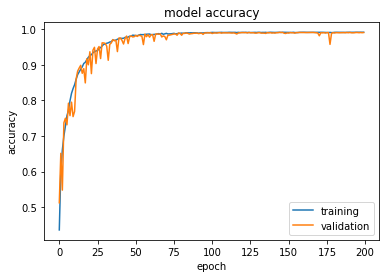

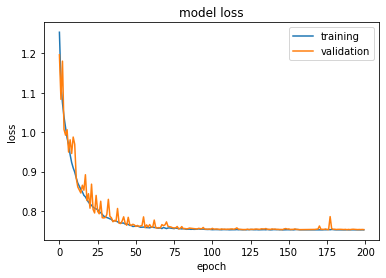

In [31]:
from matplotlib import pyplot as plt
# 学習状況のプロット関数の定義
# 分類精度の履歴をプロット
plt.plot([a.cpu() for a in acc_hist[0]])
plt.plot([a.cpu() for a in acc_hist[1]])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# 損失関数の履歴をプロット
plt.plot(loss_hist[0])
plt.plot(loss_hist[1])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


# Save the model

In [32]:
model_path = RESEARCH_WORK_PATH + 'models/multimodal_5s_0.5shift_200epoch_fixed_kernel_3.pth'
torch.save(model.state_dict(), model_path)